In [1]:
import os
import tempfile
import shutil

import nibabel as nib
import numpy as np

from monai.config import print_config
from monai.data import ITKReader, ITKWriter
import matplotlib.pyplot as plt
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    Spacingd,
    CenterSpatialCropd,
    MaskIntensityd,
    ScaleIntensityd,
    MapTransform,
    Affined,
    Resized,
    Zoomd,
    SpatialPadd,
)
from monai.data import DataLoader, Dataset
import pandas as pd
import xml.etree.ElementTree as ET
from dicttoxml import dicttoxml
from xml.dom.minidom import parseString
import tools
import torch
# print_config()

In [36]:
import itk
reader = ITKReader(reverse_indexing=True, affine_lps_to_ras=False)

file_name = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_01.mha"
mask_file_name = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\moving_image_mask.mha"
filename_2DUS = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_0050_formated.mha"
mask_file_name_2DUS = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\fixed_image_mask.mha"
image_obj = reader.read(file_name)
image_array, image_meta = reader.get_data(image_obj)

mask_image_obj = reader.read(mask_file_name)
mask_image_array, mask_image_meta = reader.get_data(mask_image_obj)
print(image_array.shape)
print(image_array.T.shape)


(400, 320, 240)
(400, 320, 1)


In [ ]:
writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
writer.set_data_array(image_array.T, channel_dim=None)
writer.set_metadata(image_meta)
output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_01_output.mha"
writer.write(output_filename)

In [ ]:



# data_dict_3DUS = {'image': file_name, 'image_mask':mask_file_name}
# data_dict_2DUS = {'image': filename_2DUS, 'image_mask': mask_file_name_2DUS, 'case_ID_3DUS': '0'}


# test_image = tfm_imageLoader(data_dict_2DUS)
# origin_image = test_image['volume_name']
# print("original image shape: ", origin_image.shape)

# writer.set_data_array(origin_image.data, channel_dim=0)
# writer.set_metadata(origin_image.meta, resample=False) # to decide whether the image needs to be resampled
# output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\fixed_image_resampled.mha"
# # output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_0050_output_resample.mha"
# writer.write(output_filename)

In [24]:
from monai.config import KeysCollection
import SimpleITK as sitk
def ConvertITKTransform2NumpyArray(transform):
    """ITK transfrom: transform_from_parent_LPS."""
    rotation = transform.GetMatrix()
    translation = transform.GetTranslation()
    center = transform.GetCenter()
    rotation_array = np.array([[rotation[0], rotation[1], rotation[2]], [rotation[3], rotation[4], rotation[5]], [rotation[6], rotation[7], rotation[8]]])
    offset = -rotation_array@center + center + translation

    transform_array = np.array([[rotation[0], rotation[1], rotation[2], offset[0]], [rotation[3], rotation[4], rotation[5], offset[1]], [rotation[6], rotation[7], rotation[8], offset[2]], [0, 0, 0, 1]])
    return transform_array

def ConvertNumpyArray2ITKTransform(transform_array):
    """ITK transform: transfrom_from_parent_LPS"""
    dimension = 3
    transform = sitk.AffineTransform(dimension)
    rotation = [transform_array[0][0], transform_array[0][1], transform_array[0][2], transform_array[1][0], transform_array[1][1], transform_array[1][2], transform_array[2][0], transform_array[2][1], transform_array[2][2]]
    translation = [transform_array[0][3], transform_array[1][3], transform_array[2][3]]
    transform.SetMatrix(rotation)
    transform.SetTranslation(translation)
    return transform

def CreateLookupTable_backup(all_cases_metadata, save_flag = True):
    num_of_cases = len(all_cases_metadata) # number of volumes
    alldataset_LUT = []
    volume_LUT = []
    for case_index in range(0, num_of_cases):
        case_tree = ET.parse(all_cases_metadata[case_index].text)
        case_root = case_tree.getroot()

        # get the volume name (moving image)
        moving_image_metadata = case_root.find('moving_image')
        moving_image_fileNAME = os.path.join(moving_image_metadata.find('directory').text, moving_image_metadata.find('name_raw_US_volume').text) 

        # get the mask of volume (moving image)
        moving_image_mask_metadata = case_root.find('moving_image_mask')
        moving_image_mask_fileNAME = os.path.join(moving_image_mask_metadata.find('directory').text, moving_image_mask_metadata.find('name_rawdata').text) 

        # get the fixed image
        fixed_images_metadata = case_root.find('fixed_image')
        rangeMin = int(fixed_images_metadata.find('rangeMin').text)
        rangeMax = int(fixed_images_metadata.find('rangeMax').text)

        # get the mask of fixed image
        fixed_image_mask_metadata = case_root.find('fixed_image_mask')
        fixed_image_mask_fileNAME = os.path.join(fixed_image_mask_metadata.find('directory').text, fixed_image_mask_metadata.find('name').text)

        volume_case_dict = {'volume_ID': case_index,'volume_name': moving_image_fileNAME, "volume_mask_name": moving_image_mask_fileNAME}
        volume_LUT.append(volume_case_dict)
        # get the transform (3DUS to CT/MRI)
        tfm_3DUS_CT_metadata = case_root.find('transform_3DUS_CT')
        tfm_3DUS_CT_fileNAME = os.path.join(tfm_3DUS_CT_metadata.find('directory').text, tfm_3DUS_CT_metadata.find('name').text)

        # get the frame flip flag
        US_image_setting_metadata = case_root.find('US_image_setting')
        frame_flip_flag = US_image_setting_metadata.find("flip").text
        
        # get the transform metadata (slice to volume registration)
        tfm_RegS2V_metadata = case_root.find('slice_to_volume_registration')
        for frame_index in range(rangeMin, rangeMax + 1):
            num_letters_frame_index = len(str(frame_index))
            if num_letters_frame_index == 1:
                full_frame_index = '000' + str(frame_index)       
            elif num_letters_frame_index == 2:
                full_frame_index = '00' + str(frame_index)      
            elif num_letters_frame_index == 3:
                full_frame_index = '0' + str(frame_index)
            elif num_letters_frame_index == 4:
                full_frame_index = str(frame_index)
            else :
                print("checking out the maximum length of the filename!")
            
            # get the fixed image filename
            fixed_image_filename = "Image_" + full_frame_index + ".mha"
            fixed_image_fileNAME = os.path.join(fixed_images_metadata.find('directory').text, fixed_image_filename) 
            
            initial_frame_name = "initial_"+ full_frame_index + ".tfm"
            correction_frame_name = "correction_" + full_frame_index+ ".tfm"
            tfm_RegS2V_initial_fileNAME = os.path.join(tfm_RegS2V_metadata.find('US_directory').text, tfm_RegS2V_metadata.find('initial_folder').text, initial_frame_name)
            tfm_RegS2V_correction_fileNAME = os.path.join(tfm_RegS2V_metadata.find('US_directory').text, tfm_RegS2V_metadata.find('correction_folder').text, correction_frame_name)

            if frame_index == rangeMin:
                fixed_image_fileNAME_pre = fixed_image_fileNAME
                tfm_RegS2V_correction_fileNAME_pre = tfm_RegS2V_correction_fileNAME
            else:
                num_letters_frame_index_pre = len(str(frame_index-1))
                if num_letters_frame_index_pre == 1:
                    full_frame_index_pre = '000' + str(frame_index-1)       
                elif num_letters_frame_index_pre == 2:
                    full_frame_index_pre = '00' + str(frame_index-1)      
                elif num_letters_frame_index_pre == 3:
                    full_frame_index_pre = '0' + str(frame_index-1)
                elif num_letters_frame_index_pre == 4:
                    full_frame_index_pre = str(frame_index-1)
                else :
                    print("checking out the maximum length of the filename!")
                fixed_image_filename_pre = "Image_" + full_frame_index_pre + ".mha"
                fixed_image_fileNAME_pre = os.path.join(fixed_images_metadata.find('directory').text, fixed_image_filename_pre)

                correction_frame_name = "correction_" + full_frame_index_pre+ ".tfm"
                tfm_RegS2V_correction_fileNAME_pre = os.path.join(tfm_RegS2V_metadata.find('US_directory').text, tfm_RegS2V_metadata.find('correction_folder').text, correction_frame_name)

                # case_frame_pair = [case_index, frame_index, frame_index-1]
            # case_dict = {'volume_ID': case_index, 'volume_name': moving_image_fileNAME, "volume_mask_name": moving_image_mask_fileNAME, 
            #              "frame_name":fixed_image_fileNAME, "frame_name_pre": fixed_image_fileNAME_pre, 'frame_mask_name': fixed_image_mask_fileNAME,
            #              "tfm_3DUS_CT_fileNAME": tfm_3DUS_CT_fileNAME, "tfm_RegS2V_initial_fileNAME": tfm_RegS2V_initial_fileNAME, "tfm_RegS2V_correction_fileNAME": tfm_RegS2V_correction_fileNAME, 
            #              "tfm_RegS2V_correction_fileNAME_pre": tfm_RegS2V_correction_fileNAME_pre}
            case_dict = {'volume_ID': case_index, 
                         "frame_name":fixed_image_fileNAME,'frame_mask_name': fixed_image_mask_fileNAME,
                         "tfm_RegS2V": [tfm_3DUS_CT_fileNAME, tfm_RegS2V_initial_fileNAME, tfm_RegS2V_correction_fileNAME, tfm_RegS2V_correction_fileNAME_pre],
                         "tfm_gt_diff_mat": None, "tfm_RegS2V_initial_mat": None, "frame_flip_flag": frame_flip_flag}
            alldataset_LUT.append(case_dict)

    data_LUT_np = np.array(alldataset_LUT)
    # print("Lookuptable: ", data_LUT_np)
    # print("size of lut:", data_LUT_np.shape)
    if save_flag:
        # dataframe = pd.DataFrame(data_LUT_np, columns=['volume case ID', 'Transform ID (gt)', 'Transform ID (initial)'])
        # dataframe.to_csv(r"E:\PROGRAM\Project_PhD\Registration\Deepcode\FVR-Net\dataset_LUT.csv")
        alldataset_xml = dicttoxml(alldataset_LUT, custom_root="all_cases")
        dom = parseString(alldataset_xml)
        dom.writexml( open(r"E:\PROGRAM\Project_PhD\Registration\Deepcode\FVR-Net\alldataset_dict.xml", 'w'),
               indent="\t",
               addindent="\t",
               newl='\n')
        
        volume_dict_xml = dicttoxml(volume_LUT, custom_root="volume_cases")
        dom = parseString(volume_dict_xml)
        dom.writexml( open(r"E:\PROGRAM\Project_PhD\Registration\Deepcode\FVR-Net\volume_dict.xml", 'w'),
               indent="\t",
               addindent="\t",
               newl='\n')
        
        # print(dom.toprettyxml())
    return alldataset_LUT, volume_LUT

def CreateLookupTable(cases_metadata, dataset_dict_fileNAME, volume_dict_fileNAME, save_flag = True):
    num_of_cases = len(cases_metadata) # number of volumes
    alldataset_LUT = []
    volume_LUT = []
    for case_index in range(0, num_of_cases):
        case_tree = ET.parse(os.path.join(project_data_dir, cases_metadata[case_index].text))
        case_root = case_tree.getroot()

        # get the volume name (moving image)
        moving_image_metadata = case_root.find('moving_image')
        # moving_image_fileNAME = os.path.join(project_data_dir, moving_image_metadata.find('directory').text, moving_image_metadata.find('name_raw_US_volume').text) 
        moving_image_fileNAME = os.path.join(project_data_dir, "LHV\LHV-06\pre06_sweep02\in_moving_volumes", moving_image_metadata.find('name_raw_US_volume').text) 
        
        print("moving_image_fileNAME: ", moving_image_fileNAME)
        print("project_data_dir", project_data_dir)
        print("moving_image_metadata.find('directory').text", moving_image_metadata.find('directory').text)
        print("moving_image_metadata.find('name_raw_US_volume').text", moving_image_metadata.find('name_raw_US_volume').text)
        # get the mask of volume (moving image)
        moving_image_mask_metadata = case_root.find('moving_image_mask')
        moving_image_mask_fileNAME = os.path.join(project_data_dir, moving_image_mask_metadata.find('directory').text, moving_image_mask_metadata.find('name_rawdata').text) 

        # get the fixed image
        fixed_images_metadata = case_root.find('fixed_image')
        rangeMin = int(fixed_images_metadata.find('rangeMin').text)
        rangeMax = int(fixed_images_metadata.find('rangeMax').text)

        # get the mask of fixed image
        fixed_image_mask_metadata = case_root.find('fixed_image_mask')
        fixed_image_mask_fileNAME = os.path.join(project_data_dir, fixed_image_mask_metadata.find('directory').text, fixed_image_mask_metadata.find('name').text)

        volume_case_dict = {'volume_ID': case_index,'volume_name': moving_image_fileNAME, "volume_mask_name": moving_image_mask_fileNAME}
        volume_LUT.append(volume_case_dict)
        # get the transform (3DUS to CT/MRI)
        tfm_3DUS_CT_metadata = case_root.find('transform_3DUS_CT')
        tfm_3DUS_CT_fileNAME = os.path.join(project_data_dir, tfm_3DUS_CT_metadata.find('directory').text, tfm_3DUS_CT_metadata.find('name').text)

        # get the transform metadata (slice to volume registration)
        tfm_RegS2V_metadata = case_root.find('slice_to_volume_registration')
        for frame_index in range(rangeMin, rangeMax + 1):
            num_letters_frame_index = len(str(frame_index))
            if num_letters_frame_index == 1:
                full_frame_index = '000' + str(frame_index)       
            elif num_letters_frame_index == 2:
                full_frame_index = '00' + str(frame_index)      
            elif num_letters_frame_index == 3:
                full_frame_index = '0' + str(frame_index)
            elif num_letters_frame_index == 4:
                full_frame_index = str(frame_index)
            else :
                print("checking out the maximum length of the filename!")
            
            # get the fixed image filename
            fixed_image_filename = "Image_" + full_frame_index + ".mha"
            fixed_image_fileNAME = os.path.join(project_data_dir, fixed_images_metadata.find('directory').text, fixed_image_filename) 
            
            initial_frame_name = "initial_"+ full_frame_index + ".tfm"
            correction_frame_name = "correction_" + full_frame_index+ ".tfm"
            tfm_RegS2V_initial_fileNAME = os.path.join(project_data_dir, tfm_RegS2V_metadata.find('US_directory').text, tfm_RegS2V_metadata.find('initial_folder').text, initial_frame_name)
            tfm_RegS2V_correction_fileNAME = os.path.join(project_data_dir, tfm_RegS2V_metadata.find('US_directory').text, tfm_RegS2V_metadata.find('correction_folder').text, correction_frame_name)

            if frame_index == rangeMin:
                # fixed_image_fileNAME_pre = fixed_image_fileNAME
                tfm_RegS2V_correction_fileNAME_pre = tfm_RegS2V_correction_fileNAME
            else:
                num_letters_frame_index_pre = len(str(frame_index-1))
                if num_letters_frame_index_pre == 1:
                    full_frame_index_pre = '000' + str(frame_index-1)       
                elif num_letters_frame_index_pre == 2:
                    full_frame_index_pre = '00' + str(frame_index-1)      
                elif num_letters_frame_index_pre == 3:
                    full_frame_index_pre = '0' + str(frame_index-1)
                elif num_letters_frame_index_pre == 4:
                    full_frame_index_pre = str(frame_index-1)
                else :
                    print("checking out the maximum length of the filename!")
                # fixed_image_filename_pre = "Image_" + full_frame_index_pre + ".mha"
                # fixed_image_fileNAME_pre = os.path.join(fixed_images_metadata.find('directory').text, fixed_image_filename_pre)

                correction_frame_name = "correction_" + full_frame_index_pre+ ".tfm"
                tfm_RegS2V_correction_fileNAME_pre = os.path.join(project_data_dir, tfm_RegS2V_metadata.find('US_directory').text, tfm_RegS2V_metadata.find('correction_folder').text, correction_frame_name)

                # case_frame_pair = [case_index, frame_index, frame_index-1]
            # case_dict = {'volume_ID': case_index, 'volume_name': moving_image_fileNAME, "volume_mask_name": moving_image_mask_fileNAME, 
            #              "frame_name":fixed_image_fileNAME, "frame_name_pre": fixed_image_fileNAME_pre, 'frame_mask_name': fixed_image_mask_fileNAME,
            #              "tfm_3DUS_CT_fileNAME": tfm_3DUS_CT_fileNAME, "tfm_RegS2V_initial_fileNAME": tfm_RegS2V_initial_fileNAME, "tfm_RegS2V_correction_fileNAME": tfm_RegS2V_correction_fileNAME, 
            #              "tfm_RegS2V_correction_fileNAME_pre": tfm_RegS2V_correction_fileNAME_pre}
            case_dict = {'volume_ID': case_index, 
                         "frame_name":fixed_image_fileNAME,'frame_mask_name': fixed_image_mask_fileNAME,
                         "tfm_RegS2V": [tfm_3DUS_CT_fileNAME, tfm_RegS2V_initial_fileNAME, tfm_RegS2V_correction_fileNAME, tfm_RegS2V_correction_fileNAME_pre],
                         "tfm_gt_diff_mat": None, "tfm_gt_diff_dof": None,
                         "tfm_RegS2V_initial_mat": None, "tfm_RegS2V_gt_mat": None}
            alldataset_LUT.append(case_dict)

    data_LUT_np = np.array(alldataset_LUT)
    # print("Lookuptable: ", data_LUT_np)
    # print("size of lut:", data_LUT_np.shape)
    if save_flag:
        # dataframe = pd.DataFrame(data_LUT_np, columns=['volume case ID', 'Transform ID (gt)', 'Transform ID (initial)'])
        # dataframe.to_csv(r"E:\PROGRAM\Project_PhD\Registration\Deepcode\FVR-Net\dataset_LUT.csv")
        alldataset_xml = dicttoxml(alldataset_LUT, custom_root="all_cases")
        dom = parseString(alldataset_xml)
        dom.writexml( open(dataset_dict_fileNAME, 'w'),
               indent="\t",
               addindent="\t",
               newl='\n')
        
        volume_dict_xml = dicttoxml(volume_LUT, custom_root="volume_cases")
        dom = parseString(volume_dict_xml)
        dom.writexml( open(volume_dict_fileNAME, 'w'),
               indent="\t",
               addindent="\t",
               newl='\n')
        
        # print(dom.toprettyxml())
    return alldataset_LUT, volume_LUT

# Note: direct to home directory

project_dir = 'E:\PROGRAM\Project_PhD\Registration\DeepRegS2V'
# print(project_dir)
project_data_dir = project_dir + "\data"
project_src_dir = project_dir + "\src"
# data_tree_file = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\FVR-Net\dataset_index_test.xml"
data_tree_file = os.path.join(project_src_dir, "dataset_index_test.xml")
data_tree = ET.parse(data_tree_file)
root = data_tree.getroot()
all_cases_metadata = root.find('all_cases')
training_cases_metadata = root.find("training_cases")
validation_cases_metadata = root.find("validation_cases")

training_dataset_dict_fileNAME = os.path.join(project_src_dir, "training_dataset_dict.xml")
training_volume_dict_fileNAME = os.path.join(project_src_dir, "training_volume_dict.xml")
validation_dataset_dict_fileNAME = os.path.join(project_src_dir, "validation_dataset_dict.xml")
validation_volume_dict_fileNAME = os.path.join(project_src_dir, "validation_volume_dict.xml")


In [25]:



# alldataset_dict, volume_dict = CreateLookupTable(all_cases_metadata, save_flag=True)
training_dataset_dict, training_volume_dict = CreateLookupTable(training_cases_metadata,training_dataset_dict_fileNAME, training_volume_dict_fileNAME, save_flag=True)
validation_dataset_dict, validation_volume_dict = CreateLookupTable(validation_cases_metadata, validation_dataset_dict_fileNAME, validation_volume_dict_fileNAME, save_flag=True)
    
# print(training_dataset_dict)
print(validation_dataset_dict)




moving_image_fileNAME:  E:\LHV\LHV-06\pre06_sweep02\in_moving_volumes\Pre-Ablation_06.mha
project_data_dir E:\PROGRAM\Project_PhD\Registration\DeepRegS2V\data
moving_image_metadata.find('directory').text \LHV\LHV-06\pre06_sweep02\in_moving_volumes
moving_image_metadata.find('name_raw_US_volume').text Pre-Ablation_06.mha
moving_image_fileNAME:  E:\LHV\LHV-03\pre04_sweep04\in_moving_volumes\Pre-Ablation_04.mha
project_data_dir E:\PROGRAM\Project_PhD\Registration\DeepRegS2V\data
moving_image_metadata.find('directory').text \LHV\LHV-03\pre04_sweep04\in_moving_volumes
moving_image_metadata.find('name_raw_US_volume').text Pre-Ablation_04.mha
moving_image_fileNAME:  E:\LHV\LHV-03\pre01_sweep04\in_moving_volumes\Pre-Ablation_01.mha
project_data_dir E:\PROGRAM\Project_PhD\Registration\DeepRegS2V\data
moving_image_metadata.find('directory').text \LHV\LHV-03\pre01_sweep04\in_moving_volumes
moving_image_metadata.find('name_raw_US_volume').text Pre-Ablation_01.mha
[{'volume_ID': 0, 'frame_name': 'E

In [11]:
tfm_imageLoader = Compose(
    [
        LoadImaged(keys=["volume_name", "volume_mask_name"], reader=ITKReader(reverse_indexing=False, affine_lps_to_ras=False),image_only=False),
        MaskIntensityd(keys=["volume_name"], mask_key= "volume_mask_name"),
        EnsureChannelFirstd(keys = ["volume_name"]),
        Spacingd(keys=["volume_name"], pixdim=(0.5, 0.5, 0.5), mode=("bilinear"))
    ]
)

# test_image = tfm_imageLoader(validation_volume_dict)
test_image = tfm_imageLoader(training_volume_dict)
origin_image = test_image[0]['volume_name']
print("original image shape: ", origin_image.shape)




original image shape:  torch.Size([1, 480, 361, 365])


In [12]:
origin_image.meta
torch.permute(origin_image.data, (0, 3, 2, 1)).shape


torch.Size([1, 365, 361, 480])

In [ ]:

writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
writer.set_data_array(origin_image.data, channel_dim=0)
writer.set_metadata(origin_image.meta, resample=False)
output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_01_output.mha"
writer.write(output_filename)


# writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
# writer.set_data_array(torch.permute(origin_image.data, (0, 3, 2, 1)), channel_dim=0)
# writer.set_metadata(origin_image.meta, resample=False)
# output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_01_output.mha"
# writer.write(output_filename)


In [8]:
def transform_conversion_pytorch_to_ITK(affine_transform_pytorch_initial, affine_transform_pytorch_correction, volume_size):
    #note: affine_transform_ITK (to parent)
    """ to calucate the affine_transorm_ITK, when you get the output from our network"""
    """our network is to cacluate the correction transform, assuming we already have a good iniital transform (affine_transform_ITK_initial)"""
    affine_transform_pytorch = affine_transform_pytorch_correction@affine_transform_pytorch_initial
    T_normalized = np.array([[2/volume_size[0], 0, 0, 0], [0, 2/volume_size[1], 0, 0], [0, 0, 2/volume_size[2], 0], [0, 0, 0, 1]]) # LPS to parent
    affine_transform_ITK = np.linalg.inv(T_normalized) @ affine_transform_pytorch @ T_normalized

    return affine_transform_ITK

def transform_conversion_pytorch_to_original_ITK(affine_transform_pytorch_initial, affine_transform_pytorch_correction, volume_size, frame_spacing, frame_size, scale):
    # TODO: need to test the correctness
    #note: affine_transform_ITK (to parent); affine_transform_original_ITK (to parent)
    """ to calucate the affine_transorm_ITK, when you get the output from our network"""
    """our network is to cacluate the correction transform, assuming we already have a good iniital transform (affine_transform_ITK_initial)"""
    affine_transform_pytorch = affine_transform_pytorch_correction@affine_transform_pytorch_initial
    T_normalized = np.array([[2/volume_size[0], 0, 0, 0], [0, 2/volume_size[1], 0, 0], [0, 0, 2/volume_size[2], 0], [0, 0, 0, 1]]) # LPS to parent
    affine_transform_ITK = np.linalg.inv(T_normalized) @ affine_transform_pytorch @ T_normalized
    
    T_scale = np.array([[scale, 0, 0, 0], [0, scale, 0, 0], [0, 0, scale, 0], [0, 0, 0, 1]]) # LPS to parent
    T_scale_inv = np.linalg.inv(T_scale)
    
    T_translate = np.array([[1, 0, 0, 0], [0, 1, 0, -frame_spacing[1]*frame_size[1]*0.5], [0, 0, 1, 0], [0, 0, 0, 1]]) # LPS to parent
    T_translate_inv = np.linalg.inv(T_translate)
    #tfm_RegS2V_gt_np_to = T_scale@T_translate@tfm_RegS2V_gt_np_to@T_scale_inv
    affine_transform_original_ITK = T_translate_inv@T_scale_inv@affine_transform_ITK@T_scale

    return affine_transform_original_ITK

def transform_conversion_ITK_to_pytorch(affine_transform_ITK, volume_size):
    # note: affine_transform_ITK (to parent)
    """to achieve the conversion of transform from the ITK transformation to pytorch transformation"""
    """For the input and output objects, both of them are rescaled to spacing (1mm, 1mm, 1mm) and recentered the volume, which is to fake the pytorch transform"""
    """For the pytorch, the input and output are the torches, which dont have the spacing information, so we can treat them as 1."""
    """To understand how the transform_ITK and transform_pytorch can work well and know the relationship, we need to bring anther package (Scipy) to help us"""
    """The conversion workflow is: transform_ITK -> transform_scipy -> transform_pytorch"""
    """For the scipy, the input and outout dont have the spacing information, which are the same as the pytorch transform. Differently, the input and output are represented as [1, 2,..., N_w] by [1, 2, ..., N_h] by [1, 2, ..., N_d].
    And the transform_scipy is applied around the first voxel [0, 0, 0] by default. If the volume center is set as the (0, 0, 0) in spatial domain, we need to translate the transform_ITK to the center of volume first T_translate, 
    then apply the transform_ITK, after that, we need to translate back the object."""
    """For the pytorch, the transformation is similiar as the transform_scipy. Differently, the input and ouput need to be normalized first. That means that instead of representing by [1, 2,..., N_w] by [1, 2, ..., N_h] by [1, 2, ..., N_d], 
    the input and output are represented by [-1,,..., 0, ..., 1] by [-1,,..., 0, ..., 1] by [-1,,..., 0, ..., 1]. For the numpy array input, the grid_sample will recoginize them as 
    [-N_w/2, ..., -2, -1, 0, 1, 2, ..., N_w/2] by [-N_h/2, ..., -2, -1, 0, 1, 2, ..., N_h/2] by [-N_d/2, ..., -2, -1, 0, 1, 2, ..., N_d/2]"""
    
    # print(image_array_volume)
    # affine_transform_ITK = data_2DUS[21]["tfm_RegS2V_gt_mat"].numpy()
    # affine_transform = np.array([[np.cos(45*np.pi/180), -np.sin(45*np.pi/180), 0, 0], [np.sin(45*np.pi/180), np.cos(45*np.pi/180), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) # LPS to parent

    
    affine_transform_inverse = np.linalg.inv(affine_transform_ITK) # for the grid_sampling, the transform is inversed
    """transform_scipy -> transform_pytorch"""
    # T_normalized = np.array([[2/volume_size[0], 0, 0, -1], [0, 2/volume_size[1], 0, -1], [0, 0, 2/volume_size[2], -1], [0, 0, 0, 1]]) # LPS to parent
    T_normalized = np.array([[2/volume_size[0], 0, 0, 0], [0, 2/volume_size[1], 0, 0], [0, 0, 2/volume_size[2], 0], [0, 0, 0, 1]]) # LPS to parent
    affine_transform_pytorch = T_normalized @ affine_transform_inverse @ np.linalg.inv(T_normalized)
    
    return affine_transform_pytorch # 4 by 4

def transform_conversion_ITK_to_scipy(affine_transform_ITK, volume_size):
    #note: affine_transform_ITK (to parent)
    """to achieve the conversion of transform from the ITK transformation to pytorch transformation"""
    """For the input and output objects, both of them are rescaled to spacing (1mm, 1mm, 1mm) and recentered the volume, which is to fake the pytorch transform"""
    """For the pytorch, the input and output are the torches, which dont have the spacing information, so we can treat them as 1."""
    """To understand how the transform_ITK and transform_pytorch can work well and know the relationship, we need to bring anther package (Scipy) to help us"""
    """The conversion workflow is: transform_ITK -> transform_scipy -> transform_pytorch"""
    """For the scipy, the input and outout dont have the spacing information, which are the same as the pytorch transform. Differently, the input and output are represented as [1, 2,..., N_w] by [1, 2, ..., N_h] by [1, 2, ..., N_d].
    And the transform_scipy is applied around the first voxel [0, 0, 0] by default. If the volume center is set as the (0, 0, 0) in spatial domain, we need to translate the transform_ITK to the center of volume first T_translate, 
    then apply the transform_ITK, after that, we need to translate back the object."""
    """For the pytorch, the transformation is similiar as the transform_scipy. Differently, the input and ouput need to be normalized first. That means that instead of representing by [1, 2,..., N_w] by [1, 2, ..., N_h] by [1, 2, ..., N_d], 
    the input and output are represented by [-1,,..., 0, ..., 1] by [-1,,..., 0, ..., 1] by [-1,,..., 0, ..., 1]. Therefore, based on transform_scipy, we need to renormalized the input first, then apply transform_scipy, after that re-normalized back the ojects"""
    
    # print(image_array_volume)
    # affine_transform_ITK = data_2DUS[21]["tfm_RegS2V_gt_mat"].numpy()
    # affine_transform = np.array([[np.cos(45*np.pi/180), -np.sin(45*np.pi/180), 0, 0], [np.sin(45*np.pi/180), np.cos(45*np.pi/180), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) # LPS to parent

    """transform_ITK -> transform_scipy"""
    T_translate = np.array([[1, 0, 0, -volume_size[0]*0.5], [0, 1, 0, -volume_size[1]*0.5], [0, 0, 1, -volume_size[2]*0.5], [0, 0, 0, 1]]) # LPS to parent
    affine_transform_scipy = np.linalg.inv(T_translate)@affine_transform_ITK@T_translate

    return affine_transform_scipy # 4 by 4

class LoadRegistrationTransformd(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False, scale = 1, volume_size = None) -> None:
        super().__init__(keys, allow_missing_keys)
        self.keys = keys
        self.scale = scale
        self.volume_size = volume_size #"W*H*D"
    def __call__(self, data):
        """Keys tfm_3DUS_CT_fileNAME: ["tfm_3DUS_CT_fileNAME", "tfm_RegS2V_initial_fileNAME", "tfm_RegS2V_correction_fileNAME", "tfm_RegS2V_correction_fileNAME_pre"]""" 
        for key in self.keys:
            tfm_3DUS_CT = sitk.ReadTransform(data[key][0]) # transform (from parent) LPS
            # print(tfm_3DUS_CT)
            tfm_3DUS_CT_np = ConvertITKTransform2NumpyArray(tfm_3DUS_CT) # from parent
            # print("tfm_3DUS_CT", np.linalg.inv(tfm_3DUS_CT_np))

            tfm_RegS2V_initial = sitk.ReadTransform(data[key][1]) # transform (from parent) LPS
            # print(tfm_RegS2V_initial)
            tfm_RegS2V_initial_np = ConvertITKTransform2NumpyArray(tfm_RegS2V_initial) # from parent
            # print("tfm_RegS2V_initial", np.linalg.inv(tfm_RegS2V_initial_np))

            tfm_RegS2V_correction = sitk.ReadTransform(data[key][2]) # transform (from parent) LPS
            tfm_RegS2V_correction_np = ConvertITKTransform2NumpyArray(tfm_RegS2V_correction) # from parent
            # print("tfm_RegS2V_correction", np.linalg.inv(tfm_RegS2V_correction_np))
            
            """add fake scaling and translation, this is for training. since the networks don't support to identify the spacing of the data array, we rescaled the data to spacing 1"""
            T_scale = np.array([[self.scale, 0, 0, 0], [0, self.scale, 0, 0], [0, 0, self.scale, 0], [0, 0, 0, 1]]) # LPS to parent
            T_scale_inv = np.linalg.inv(T_scale)
            frame_fileNAME = data["frame_name"]
            # print(frame_fileNAME)
            reader = sitk.ImageFileReader()
            reader.SetFileName(frame_fileNAME)
            reader.LoadPrivateTagsOn()
            reader.ReadImageInformation()
            spacing = reader.GetSpacing()
            size = reader.GetSize()
            T_translate = np.array([[1, 0, 0, 0], [0, 1, 0, -spacing[1]*size[1]*0.5], [0, 0, 1, 0], [0, 0, 0, 1]]) # LPS to parent
            # print(T_translate)

            """original transform_ITK (ground truth)"""
            tfm_RegS2V_gt_np_from = tfm_3DUS_CT_np@tfm_RegS2V_initial_np@tfm_RegS2V_correction_np # from parent
            tfm_RegS2V_gt_np_to = np.linalg.inv(tfm_RegS2V_gt_np_from) # (ground truth) to parent
            # print("gt transform: {}".format(tfm_RegS2V_gt_np_to))
            # print("T_translate: {}".format(T_scale_inv))
            """transform_ITK to fake the pytorch transform (rescaled and recentered the orignal one)"""
            tfm_RegS2V_gt_np_to = T_scale@T_translate@tfm_RegS2V_gt_np_to@T_scale_inv # this is the affine_transform_ITK
            # print("tfm_RegS2v_gt_np: {}".format(tfm_RegS2V_gt_np_to))
            """get transform_pytorch"""
            tfm_RegS2V_gt_pytorch = transform_conversion_ITK_to_pytorch(tfm_RegS2V_gt_np_to, self.volume_size) # this is the affine_transform_pytorch
            tfm_RegS2V_gt_mat_tensor = torch.from_numpy(tfm_RegS2V_gt_pytorch) 


            """original transform_ITK (initial one)"""
            tfm_RegS2V_correction_pre = sitk.ReadTransform(data[key][3]) # transform (from parent) LPS
            tfm_RegS2V_correction_np_pre = ConvertITKTransform2NumpyArray(tfm_RegS2V_correction_pre) # from parent
            tfm_RegS2V_initial_np_from = tfm_3DUS_CT_np@tfm_RegS2V_initial_np@tfm_RegS2V_correction_np_pre # from parent
            tfm_RegS2V_initial_np_to = np.linalg.inv(tfm_RegS2V_initial_np_from) # (initial transform) to parent
            # print("initial transform:", tfm_RegS2V_initial_np_to)
            """transform_ITK to fake the pytorch transform (rescaled and recentered the orignal one)"""
            tfm_RegS2V_initial_np_to = T_scale@T_translate@tfm_RegS2V_initial_np_to@T_scale_inv  # this is the affine_transform_ITK
            """get transform_pytorch"""
            tfm_RegS2V_initial_pytorch = transform_conversion_ITK_to_pytorch(tfm_RegS2V_initial_np_to, self.volume_size) # this is the affine_transform_pytorch
            tfm_RegS2V_initial_mat_tensor = torch.from_numpy(tfm_RegS2V_initial_pytorch)
            """caculate the different between the initial one and ground truth, which is for training"""

            # # """this is based on the transform_ITK, we decided to use the transform_pytorch to train our model, see below"""
            # tfm_gt_diff_mat = tfm_RegS2V_gt_np_to@np.linalg.inv(tfm_RegS2V_initial_np_to)
            # tfm_gt_diff_mat_tensor = torch.from_numpy(tfm_gt_diff_mat)
            # tfm_gt_diff_dof = tools.mat2dof_np(input_mat=tfm_gt_diff_mat)
            # tfm_gt_diff_dof_tensor = torch.from_numpy(tfm_gt_diff_dof[:6])
            # # tfm_RegS2V_initial_mat_tensor = torch.from_numpy(tfm_RegS2V_initial_np_to)

            tfm_gt_diff_mat = tfm_RegS2V_gt_pytorch@np.linalg.inv(tfm_RegS2V_initial_pytorch)
            tfm_gt_diff_mat_tensor = torch.from_numpy(tfm_gt_diff_mat)
            
            tfm_gt_diff_dof = tools.mat2dof_np(input_mat=tfm_gt_diff_mat)
            tfm_gt_diff_dof_tensor = torch.from_numpy(tfm_gt_diff_dof[:6])
            

            data["tfm_gt_diff_mat"] = tfm_gt_diff_mat_tensor
            data["tfm_gt_diff_dof"] = tfm_gt_diff_dof_tensor
            data["tfm_RegS2V_initial_mat"] = tfm_RegS2V_initial_mat_tensor
            data["tfm_RegS2V_gt_mat"] = tfm_RegS2V_gt_mat_tensor
        return data

In [33]:
reader = sitk.ImageFileReader()

reader.SetFileName(r"E:\PROGRAM\Project_PhD\Registration\Results\3_slice2volumeRegistration\LHV\LHV-06\pre06_sweep02\in_reordered_images_mha\Image_0027.mha")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()
spacing = reader.GetSpacing()
size = reader.GetSize()
print(size[0])
print("spacing: {}, size: {}".format(spacing, size))
scale = 2
T_scale = np.array([[scale, 0, 0, 0], [0, scale, 0, 0], [0, 0, scale, 0], [0, 0, 0, 1]])
print(T_scale)
T_scale_inv = np.linalg.inv(T_scale)
print(T_scale_inv)
T_translate = np.array([[1, 0, 0, 0], [0, 1, 0, -spacing[1]*size[1]*0.5], [0, 0, 1, 0], [0, 0, 0, 1]]) # LPS to parent
print("T_translate: {}".format(T_translate))

validation_dataset_dict[0]["frame_name"]

752
spacing: (0.25099998712539673, 0.25099998712539673, 1.0), size: (752, 558, 1)
[[2 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 1]]
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  1. ]]
T_translate: [[  1.           0.           0.           0.        ]
 [  0.           1.           0.         -70.02899641]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


'E:\\PROGRAM\\Project_PhD\\Registration\\Results\\3_slice2volumeRegistration\\LHV\\LHV-06\\pre06_sweep02\\in_reordered_images_mha\\Image_0016.mha'

In [38]:
resample_spacing = 0.5
resize_scale = 1/resample_spacing
resize_scale
spatial_size = [400, 320, 240]
transform_3DUS = Compose(
    [
        LoadImaged(keys=["volume_name", "volume_mask_name"], reader=ITKReader(reverse_indexing=False, affine_lps_to_ras=False), image_only=False), # N*C*D*H*W
        # MaskIntensityd(keys=["image","image_mask"], mask_data= mask_image_array),
        MaskIntensityd(keys=["volume_name"], mask_key= "volume_mask_name"),
        EnsureChannelFirstd(keys = ["volume_name"]),
        Spacingd(keys=["volume_name"], pixdim=(resample_spacing, resample_spacing, resample_spacing), mode=("bilinear")),
        SpatialPadd(keys=["volume_name"], spatial_size=[spatial_size[0], spatial_size[1], spatial_size[2]], method="symmetric", mode="constant"),
        CenterSpatialCropd(keys=["volume_name"], roi_size=[spatial_size[0], spatial_size[1], spatial_size[2]]), # when the spacing is 0.5*0.5*0.5 (W*H*D)
        # CenterSpatialCropd(keys=["volume_name"], roi_size=[260, 300, 380]), # when the spacing is 0.5*0.5*0.5 (D*H*W)
        ScaleIntensityd(keys=["volume_name"], minv= 0.0, maxv = 1.0, dtype= np.float32),
    ]
)


# data_3DUS = transform_3DUS(validation_volume_dict)
data_3DUS = transform_3DUS(training_volume_dict)


In [39]:

transformed_image_3DUS = data_3DUS[0]['volume_name']
print(transformed_image_3DUS.shape)

if False:
    writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
    writer.set_data_array(data_3DUS[0]['volume_name'].data, channel_dim=0)
    writer.set_metadata(data_3DUS[0]["volume_name"].meta, resample=False)
    output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_06_transformed.mha"
    writer.write(output_filename)


torch.Size([1, 400, 320, 240])


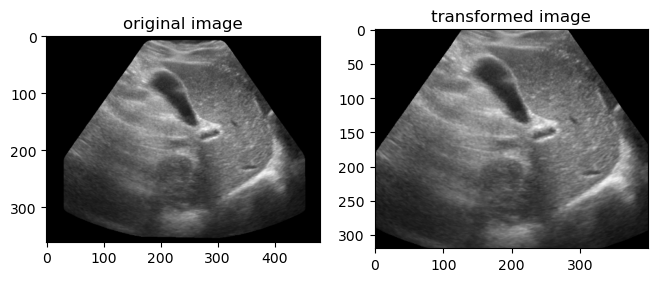

In [40]:
plt.figure("visualize", (12,8))
plt.subplot(1,3,1)
plt.title("original image")
plt.imshow(np.transpose(origin_image[0,:,:,int(origin_image.shape[3]/2)]), cmap="gray")

plt.subplot(1,3,2)
plt.title("transformed image")
plt.imshow(np.transpose(transformed_image_3DUS[0, :,:,int(transformed_image_3DUS.shape[3]/2)]), cmap="gray")

# plt.subplot(1,3,3)
# plt.title("resampled image")
# plt.imshow(resampled_image[0,0,int(resampled_image.shape[2]/2), :,:], cmap="gray")

In [41]:
volume_size = [400, 320, 240] # W*H*D
transform_2DUS = Compose(
    [
        LoadRegistrationTransformd(keys=["tfm_RegS2V"], scale=2, volume_size=volume_size),
        LoadImaged(keys=["frame_name", "frame_mask_name"], reader=ITKReader(reverse_indexing=False, affine_lps_to_ras=False), image_only=False),
        # MaskIntensityd(keys=["image","image_mask"], mask_data= mask_image_array),
        MaskIntensityd(keys=["frame_name"], mask_key= "frame_mask_name"),
        EnsureChannelFirstd(keys = ["frame_name"]),
        Spacingd(keys=["frame_name"], pixdim=(resample_spacing, resample_spacing, resample_spacing), mode=("bilinear")),
        SpatialPadd(keys=["frame_name"], spatial_size=[spatial_size[0], spatial_size[1], 1], method="symmetric", mode="constant"),
        CenterSpatialCropd(keys=["frame_name"], roi_size=[spatial_size[0], spatial_size[1], 1]), # when the spacing is 0.5*0.5*0.5
        ScaleIntensityd(keys=["frame_name"], minv= 0.0, maxv = 1.0, dtype= np.float32)
    ]
)

# data_2DUS = transform_2DUS(validation_dataset_dict)
data_2DUS = transform_2DUS(training_dataset_dict)

In [42]:
data_2DUS[0]["tfm_RegS2V_gt_mat"]

tensor([[ 0.9823,  0.1500, -0.0038, -0.0091],
        [-0.2332,  0.9798,  0.0540,  0.1082],
        [ 0.0329, -0.0928,  0.9974, -0.1182],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [43]:
data_2DUS[0]["frame_name"].shape
# print(data_2DUS)

if False:
    writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
    writer.set_data_array(data_2DUS[11]['frame_name'].data, channel_dim=0)
    writer.set_metadata(data_2DUS[11]["frame_name"].meta, resample=False)
    output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_27_transformed.mha"
    writer.write(output_filename)

In [17]:
from utils import transformations as tfms
import math
def computeScale(input_mat):
    scale1 = np.linalg.norm(input_mat[:3, 0])
    scale2 = np.linalg.norm(input_mat[:3, 1])
    scale3 = np.linalg.norm(input_mat[:3, 2])
    # print('scale1 {}'.format(scale1))
    # print('scale2 {}'.format(scale2))
    # print('scale3 {}'.format(scale3))
    # print(0.478425 * 0.35)
    # sys.exit()
    return np.asarray([scale1, scale2, scale3])

def mat2dof_np(input_mat):
    # print('input_mat\n{}'.format(input_mat))
    translations = input_mat[:3, 3]
    rotations_eulers = np.asarray(tfms.euler_from_matrix(input_mat, 'rxyz'))
    rotations_degrees = (rotations_eulers / (2 * math.pi)) * 360
    scales = computeScale(input_mat=input_mat)

    dof = np.concatenate((translations, rotations_degrees, scales), axis=0)

    # print('dof\n{}\n'.format(dof))
    # sys.exit()
    return dof

def dof2mat_np(input_dof, scale=False):
    """ Transfer degrees to euler """
    dof = input_dof
    # print('deg {}'.format(dof[3:6]))
    dof[3:6] = dof[3:6] * (2 * math.pi) / 360.0
    # print('rad {}'.format(dof[3:6]))


    rot_mat = tfms.euler_matrix(dof[3], dof[4], dof[5], 'rxyz')[:3, :3]

    mat44 = np.identity(4)
    mat44[:3, :3] = rot_mat
    mat44[:3, 3] = dof[:3]

    if scale:
        scales = dof[6:]
        mat_scale = np.diag([scales[1], scales[0], scales[2], 1])
        mat44 = np.dot(mat44, np.linalg.inv(mat_scale))
    # print('mat_scale\n{}'.format(mat_scale))
    # print('recon mat\n{}'.format(mat44))
    # sys.exit()
    return mat44

In [21]:

import scipy
reader = ITKReader(reverse_indexing=False, affine_lps_to_ras=False)

file_name = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_06_transformed_scaled.mha"
# filename_2DUS = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_27_transformed_scaled.mha"
filename_2DUS = r"E:\PROGRAM\Project_PhD\Registration\Results\3_slice2volumeRegistration\LHV\LHV-06\pre06_sweep02\in_reordered_images_mha\Image_0047.mha"
image_obj = reader.read(file_name)
image_array_volume, image_meta_volume = reader.get_data(image_obj)
image_obj = reader.read(filename_2DUS)
image_array_frame, image_meta_frame = reader.get_data(image_obj)

# print(image_array_volume.shape)
# print(image_array_frame.shape)

# print(image_array_volume)
# affine_transform = data_2DUS[31]["tfm_RegS2V_gt_mat"].numpy()
angle = math.pi/4
direction_z = np.array([0, 0, 1])
direction_y = np.array([0, 1, 0])
direction_x = np.array([1, 0, 0])
T0 = tfms.translation_matrix([10, 20, 30])
affine_transform_ITK = T0@tfms.rotation_matrix(angle, direction_z, point=None) @ tfms.rotation_matrix(angle, direction_y, point=None)@tfms.rotation_matrix(angle, direction_x, point=None)
print("affine_transform_ITK_gt: {}".format(affine_transform_ITK))


affine_transform_scipy = transform_conversion_ITK_to_scipy(affine_transform_ITK, volume_size=volume_size)
# print(affine_transform_scipy)
affine_transform_scipy_inv = np.linalg.inv(affine_transform_scipy)
# print(affine_transform_scipy_inv)
transformed_volume = scipy.ndimage.affine_transform(image_array_volume, affine_transform_scipy_inv, output_shape= (400, 320, 240), mode = 'constant')



affine_transform_ITK_gt: [[ 0.5        -0.14644661  0.85355339 10.        ]
 [ 0.5         0.85355339 -0.14644661 20.        ]
 [-0.70710678  0.5         0.5        30.        ]
 [ 0.          0.          0.          1.        ]]


In [22]:

volume = data_3DUS[0]['volume_name']
# print("volume shape: {}".format(volume.shape))
volume = volume.unsqueeze(0).type(torch.FloatTensor)
volume = torch.permute(volume, (0, 1, 4, 3, 2)).type(torch.FloatTensor)
print("volume shape(torch): {}".format(volume.shape))


angle = -math.pi/4
direction_z = np.array([0, 0, 1])
direction_y = np.array([0, 1, 0])
T0_inverse = tfms.translation_matrix([-10, -20, -30])


affine_transform_pytorch = transform_conversion_ITK_to_pytorch(affine_transform_ITK, volume_size)
# affine_transform_pytorch = data_2DUS[index]["tfm_RegS2V_gt_mat"].numpy()
print("affine_transform_pytorch: {}".format(affine_transform_pytorch))
affine_transform_pytorch_theta = affine_transform_pytorch[0:3,:]
T_affine_transform_theta = torch.from_numpy(affine_transform_pytorch_theta).type(torch.FloatTensor)
T_affine_transform_theta = T_affine_transform_theta.unsqueeze(0)

grid = F.affine_grid(T_affine_transform_theta, torch.Size([1, 1, volume_size[2], volume_size[1], volume_size[0]]), align_corners=True)
# grid = F.affine_grid(T_affine_transform_theta, torch.Size([1, 1, volume_size[0], volume_size[1], volume_size[2]]), align_corners=True)
resampled_volume = F.grid_sample(volume, grid=grid, align_corners=True)

resampled_image_np = torch.Tensor.numpy(resampled_volume)

volume shape(torch): torch.Size([1, 1, 240, 320, 400])
affine_transform_pytorch: [[ 0.5         0.4        -0.42426407  0.03106602]
 [-0.18305826  0.85355339  0.375      -0.19129126]
 [ 1.42258898 -0.19526215  0.5        -0.17172168]
 [ 0.          0.          0.          1.        ]]


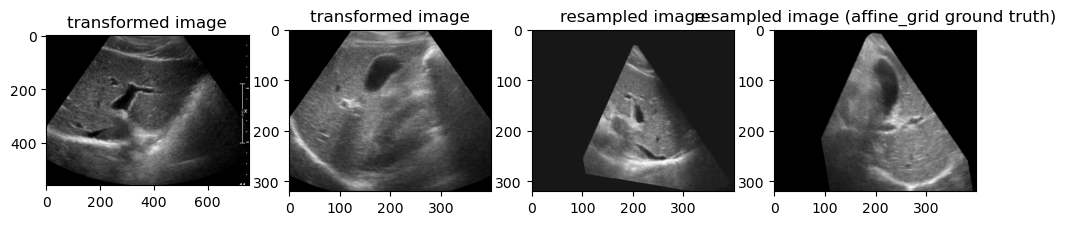

In [23]:
frame = data_2DUS[31]["frame_name"]
frame_np = torch.Tensor.numpy(frame)
# print("frame shape: {}".format(frame.shape))

plt.figure("visualize", (12,8))
plt.subplot(1,4,1)
# plt.title("original image")
# plt.imshow(np.transpose(image_array_volume[:,:,int(image_array_volume.shape[2]/2)]), cmap="gray")
plt.title("transformed image")
plt.imshow(np.transpose(image_array_frame[:,:,int(image_array_frame.shape[2]/2)]), cmap="gray")

plt.subplot(1,4,2)
# plt.title("transformed image")
# plt.imshow(np.transpose(image_array_frame[:,:,int(image_array_frame.shape[2]/2)]), cmap="gray")

plt.title("transformed image")
# plt.imshow(np.transpose(image_array_frame[:,:,int(image_array_frame.shape[2]/2)]), cmap="gray")
plt.imshow(np.transpose(frame_np[0, :,:,0]), cmap="gray")

plt.subplot(1,4,3)
plt.title("resampled image")
plt.imshow(np.transpose(transformed_volume[:,:,int(transformed_volume.shape[2]/2)]), cmap="gray")

plt.subplot(1,4,4)
plt.title("resampled image (affine_grid ground truth)")
plt.imshow(resampled_image_np[0, 0, int(resampled_image_np.shape[2]/2), :, :], cmap="gray")

In [390]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha) * fixed + alpha * moving
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

interact(display_images_with_alpha,alpha=(0.0, 1.0, 0.05),fixed=fixed(np.transpose(frame_np[0, :,:,0])),moving=fixed(np.transpose(transformed_volume[:,:,int(transformed_volume.shape[2]/2)])),)


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

<function __main__.display_images_with_alpha(alpha, fixed, moving)>

In [47]:
index = 67
# calculate the affine transform
affine_transform_pytorch = data_2DUS[index]["tfm_RegS2V_gt_mat"].numpy()

print("affine_transform_ITK_gt: {}".format(affine_transform_pytorch))

volume_size = [400, 320, 240] # W*H*D




"""ground truth transform"""
# affine_transform_pytorch = transform_conversion_ITK_to_pytorch(affine_transform_ITK, volume_size)
# affine_transform_pytorch = data_2DUS[index]["tfm_RegS2V_gt_mat"].numpy()
print("affine_transform_pytorch: {}".format(affine_transform_pytorch))
affine_transform_pytorch_theta = affine_transform_pytorch[0:3,:]
T_affine_transform_theta = torch.from_numpy(affine_transform_pytorch_theta).type(torch.FloatTensor)
T_affine_transform_theta = T_affine_transform_theta.unsqueeze(0)

"""initial transform"""
affine_transform_pytorch_initial = data_2DUS[index]["tfm_RegS2V_initial_mat"].numpy()
# print("affine_transform_ITK_initial: {}".format(affine_transform_ITK_initial))
# affine_transform_pytorch_initial = transform_conversion_ITK_to_pytorch(affine_transform_ITK_initial, volume_size)
# affine_transform_pytorch_initial = data_2DUS[index]["tfm_RegS2V_initial_mat"].numpy()
print("affine_transform_pytorch_initial: {}".format(affine_transform_pytorch_initial))



affine_transform_pytorch_initial_theta = affine_transform_pytorch_initial[0:3,:]
T_affine_transform_initial_theta = torch.from_numpy(affine_transform_pytorch_initial_theta).type(torch.FloatTensor)
T_affine_transform_initial_theta = T_affine_transform_initial_theta.unsqueeze(0)


# get the volume and frame data
frame = data_2DUS[index]["frame_name"]
frame_np = torch.Tensor.numpy(frame)
# print("frame shape: {}".format(frame.shape))

volume = data_3DUS[1]['volume_name']
# print("volume shape: {}".format(volume.shape))
volume = volume.unsqueeze(0).type(torch.FloatTensor)
volume = torch.permute(volume, (0, 1, 4, 3, 2)).type(torch.FloatTensor)
print("volume shape(torch): {}".format(volume.shape))



affine_transform_ITK_gt: [[ 0.93393807 -0.00565395 -0.21441591 -0.10503626]
 [-0.00859838  0.99925972 -0.02828816  0.01543987]
 [ 0.59561552  0.05026426  0.93320181  0.08379959]
 [ 0.          0.          0.          1.        ]]
affine_transform_pytorch: [[ 0.93393807 -0.00565395 -0.21441591 -0.10503626]
 [-0.00859838  0.99925972 -0.02828816  0.01543987]
 [ 0.59561552  0.05026426  0.93320181  0.08379959]
 [ 0.          0.          0.          1.        ]]
affine_transform_pytorch_initial: [[ 0.95080159 -0.00228386 -0.18586884 -0.0988564 ]
 [-0.01606876  0.99872888 -0.03647575  0.02145418]
 [ 0.51588935  0.06698415  0.94956025  0.07263372]
 [ 0.          0.          0.          1.        ]]
volume shape(torch): torch.Size([1, 1, 240, 320, 400])


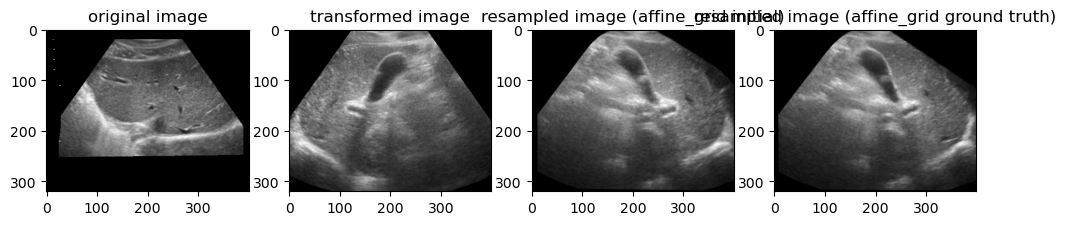

In [48]:

# import torch.nn.functional as F
# import torchgeometry as tgm
grid = F.affine_grid(T_affine_transform_theta, torch.Size([1, 1, volume_size[2], volume_size[1], volume_size[0]]), align_corners=True)
# grid = F.affine_grid(T_affine_transform_theta, torch.Size([1, 1, volume_size[0], volume_size[1], volume_size[2]]), align_corners=True)
resampled_volume = F.grid_sample(volume, grid=grid, align_corners=True)

resampled_image_np = torch.Tensor.numpy(resampled_volume)
# print("resampled_image_np shape(torch): {}".format(resampled_image_np.shape))


grid_initial = F.affine_grid(T_affine_transform_initial_theta, torch.Size([1, 1, volume_size[2], volume_size[1], volume_size[0]]), align_corners=True)
# grid_initial = F.affine_grid(T_affine_transform_initial_theta, torch.Size([1, 1, volume_size[0], volume_size[1], volume_size[2]]), align_corners=True)
resampled_volume_initial = F.grid_sample(volume, grid=grid_initial, align_corners=True)
resampled_image_initial_np = torch.Tensor.numpy(resampled_volume_initial)
# print("resampled_image_initial_np shape(torch): {}".format(resampled_image_initial_np.shape))



plt.figure("visualize", (12,8))
plt.subplot(1,4,1)
plt.title("original image")
plt.imshow(np.transpose(image_array_volume[:,:,int(image_array_volume.shape[2]/2)]), cmap="gray")

plt.subplot(1,4,2)
plt.title("transformed image")
# plt.imshow(np.transpose(image_array_frame[:,:,int(image_array_frame.shape[2]/2)]), cmap="gray")
plt.imshow(np.transpose(frame_np[0, :,:,0]), cmap="gray")

plt.subplot(1,4,3)
plt.title("resampled image (affine_grid initial)")
plt.imshow(resampled_image_initial_np[0,0,int(resampled_image_initial_np.shape[2]/2), :, :], cmap="gray")
# plt.imshow(np.transpose(resampled_image_initial_np[0,0,:, :, int(resampled_image_initial_np.shape[4]/2)]), cmap="gray")

plt.subplot(1,4,4)
plt.title("resampled image (affine_grid ground truth)")
plt.imshow(resampled_image_np[0, 0, int(resampled_image_np.shape[2]/2), :, :], cmap="gray")
# plt.imshow(resampled_image_np[0, 0, 1, :, :], cmap="gray")
# plt.imshow(np.transpose(resampled_image_np[0,0,:, :, int(resampled_image_np.shape[4]/2)]), cmap="gray")

In [398]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha) * fixed + alpha * moving
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

interact(display_images_with_alpha,alpha=(0.0, 1.0, 0.05),fixed=fixed(np.transpose(frame_np[0, :,:,0])),moving=fixed(resampled_image_initial_np[0,0,int(resampled_image_initial_np.shape[2]/2), :, :]),)


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

<function __main__.display_images_with_alpha(alpha, fixed, moving)>

print(data_2DUS)

In [ ]:

writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
writer.set_data_array(data_3DUS[0]['volume_name'].data, channel_dim=0)
writer.set_metadata(data_3DUS[0]["volume_name"].meta, resample=False)
output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_01_output.mha"
writer.write(output_filename)



In [ ]:
transform_2DUS = Compose(
    [
        LoadRegistrationTransformd(keys=["tfm_RegS2V"], scale=2),
        LoadImaged(keys=["frame_name", "frame_mask_name"], reader=ITKReader(reverse_indexing=False, affine_lps_to_ras=False), image_only=False),
        # MaskIntensityd(keys=["image","image_mask"], mask_data= mask_image_array),
        MaskIntensityd(keys=["frame_name"], mask_key= "frame_mask_name"),
        EnsureChannelFirstd(keys = ["frame_name"]),
        Spacingd(keys=["frame_name"], pixdim=(0.5, 0.5, 1.0), mode=("bilinear")),
        CenterSpatialCropd(keys=["frame_name"], roi_size=[400, 320, 1]), # when the spacing is 0.5*0.5*0.5
        # # ScaleIntensityRanged(keys=["image"], a_min= 0, a_max= a_max, b_min = 0, b_max=1, dtype=np.float32)
        ScaleIntensityd(keys=["frame_name"], minv= 0.0, maxv = 1.0, dtype= np.float32)
        
        
    ]
)

data_2DUS = transform_2DUS(validation_dataset_dict)


In [ ]:

data_2DUS_image = data_2DUS[0]["frame_name"]
data_2DUS[0]["volume_ID"]
# data_2DUS[0]["tfm_gt_diff_mat"]
# print("2D US image shape: ", data_2DUS_image.shape)
# print(f"image affine before Spacing:\n{original_image['image'].meta['affine']}")

validation_dataloader_2DUS = DataLoader(dataset=data_2DUS, batch_size=2, shuffle=False)
for batch_id, batch in enumerate(validation_dataloader_2DUS):
    print("batch shape",batch['tfm_RegS2V_initial_mat'].shape)
    if batch_id == 1:

        a = batch["tfm_gt_diff_dof"]
        print(a)

a[1]

In [ ]:

for batch_id, batch in enumerate(validation_dataloader_2DUS):
    print("batch number: ", batch_id)
    print("batch shape",batch["frame_name"].shape)
    # print("batch size: ", len(batch['volume_ID']))
    volume_size = data_3DUS[0]['volume_name'].shape
    # if batch_id == 8:
        
        # actual_batch_size = len(batch["volume_ID"])
        
        # batch_vol_tensor = torch.zeros(actual_batch_size, volume_size[0], volume_size[1], volume_size[2], volume_size[3])
        # print(batch_vol_tensor.shape)
    

        # for i, volume_id in enumerate(batch["volume_ID"]):
        #     print("volume_id: ", volume_id)
        #     batch_vol_tensor[i, :, :, :, :] = data_3DUS[volume_id]['volume_name']
    
    # print("case ID:", batch["volume_ID"])
    # vol_tensor = volumes_tensor[batch["volume_ID"]]
    # print(batch["frame_name"].shape)
    
    # volume_temp = batch[""]

    # volume_ID_tensor = batch["volume_ID"]
    # vol_tensor =  [volumes_tensor[i] 
    #               for i in volume_ID_tensor]
    

# vol_tensor


In [ ]:
import torch.nn as nn
x = torch.randn(3, 4)
print(x)
indices = torch.tensor([2])
print(indices)
torch.index_select(x, 0, indices)
# torch.index_select(x, 1, indices)

In [ ]:
batch_frame_tensor = batch["frame_name"]

batch_frame_tensor_permuted = torch.permute(batch["frame_name"], (0, 1, 4, 3, 2))

print("permuted shape: ",batch_frame_tensor_permuted.shape)

# test_image = tfm_imageLoader(validation_volume_dict)
# origin_image = test_image[0]['volume_name']
# print("original image shape: ", origin_image.shape)

plt.figure("visualize", (12,8))
plt.subplot(2,2,1)
plt.title("original image")
plt.imshow(np.transpose(batch_frame_tensor[4, 0, :,:,0]), cmap="gray")

plt.subplot(2,2,2)
plt.title("transformed image")
plt.imshow(batch_frame_tensor_permuted[4, 0, 0, :,:], cmap="gray")

In [ ]:
vol_tensor


In [ ]:
tfm_imageLoader_2DUS = Compose(
    [
        LoadImaged(keys=["frame_name", "frame_mask_name"], reader=ITKReader(reverse_indexing=False, affine_lps_to_ras=False),image_only=False),
        MaskIntensityd(keys=["frame_name"], mask_key= "frame_mask_name"),
        EnsureChannelFirstd(keys = ["frame_name"])
    ]
)

test_image = tfm_imageLoader_2DUS(validation_dataset_dict)
origin_image = test_image[0]['frame_name']

# print("original image shape: ", origin_image.shape)


plt.figure("visualize", (12,8))
plt.subplot(2,2,1)
plt.title("original image")
plt.imshow(np.transpose(origin_image[0,:,:,int(origin_image.shape[3]/2)]), cmap="gray")

plt.subplot(2,2,2)
plt.title("transformed image")
plt.imshow(np.transpose(data_2DUS_image[0, :,:,int(data_2DUS_image.shape[3]/2)]), cmap="gray")
# plt.imshow(np.transpose(data_2DUS_image[0, :,:,int(data_2DUS_image.shape[3]/2)]), cmap="gray")


# plt.subplot(2,2,3)
# plt.title("original image (mask)")
# plt.imshow(np.transpose(origin_image_mask[0,:,:,int(origin_image_mask.shape[3]/2)]), cmap="gray")

# plt.subplot(2,2,4)
# plt.title("transformed image (mask)")
# plt.imshow(np.transpose(transformed_image_mask[0, :,:,int(transformed_image_mask.shape[3]/2)]), cmap="gray")



In [ ]:

writer = ITKWriter(output_dtype=np.float32, affine_lps_to_ras= False)
writer.set_data_array(transformed_image.data, channel_dim=0)
writer.set_metadata(transformed_image.meta, resample=False) # to decide whether the image needs to be resampled
output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Pre-Ablation_01_output_resample_cropped.mha"
# output_filename = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_0050_output_resample.mha"
writer.write(output_filename)



In [ ]:
filename_2DUS = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_0050_1.mha"

data_tree_file = r"E:\PROGRAM\Project_PhD\Registration\Deepcode\FVR-Net\dataset_index.xml"
data_tree = ET.parse(data_tree_file)
root = data_tree.getroot()
all_cases_metadata = root.find('all_cases')

for case_index in range(0,len(all_cases_metadata)):
# for case_index in range(0,1):
    print(case_index)

    case_tree = ET.parse(all_cases_metadata[case_index].text)
    case_root = case_tree.getroot()


    fixed_image_metadata = case_root.find('fixed_image')
    in_renamed_directory = fixed_image_metadata.find('directory').text
    
    filenames = os.listdir(in_renamed_directory)
    num = int(filenames.__len__()) # starting from 1
    for index in range(1, num + 1):
         
        num_letters_filename = len(str(index))
        if num_letters_filename == 1:
            full_index = '000' + str(index)       
        elif num_letters_filename == 2:
            full_index = '00' + str(index)      
        elif num_letters_filename == 3:
            full_index = '0' + str(index)
        elif num_letters_filename == 4:
            full_index = str(index)
        else :
            print("checking out the maximum length of the filename!") 
        
        
        imageName = "Image_"+full_index + ".mha"
    
        fixed_image_fileNAME = os.path.join(fixed_image_metadata.find('directory').text, imageName)
        img = sitk.ReadImage(fixed_image_fileNAME)

        select = sitk.VectorIndexSelectionCastImageFilter()
        channel1_image = select.Execute(img)
        renamed_dir = fixed_image_metadata.find('directory').text + "1"
        isExist = os.path.exists(renamed_dir)
        if not isExist:
            os.makedirs(renamed_dir)
        sitk.WriteImage(channel1_image, os.path.join(renamed_dir, imageName))


In [421]:
import torchgeometry as tgm
def dof2mat_tensor(input_dof, device):
    """rotation order: matrix = rotx(ai) * roty(aj) * rotz(ak)"""
    rad = tgm.deg2rad(input_dof[:, 3:])

    ai = rad[:, 0]
    aj = rad[:, 1]
    ak = rad[:, 2]

    si, sj, sk = torch.sin(ai), torch.sin(aj), torch.sin(ak)
    ci, cj, ck = torch.cos(ai), torch.cos(aj), torch.cos(ak)
    # cc, cs = ci*ck, ci*sk
    # sc, ss = si*ck, si*sk

    M = torch.zeros((input_dof.shape[0], 4, 4))

    if device:
        M = M.to(device)
        M.requires_grad = True



    M[:, 0, 0] = cj*ck
    M[:, 0, 1] = -cj*sk
    M[:, 0, 2] = sj
    M[:, 1, 0] = si*sj*ck + ci*sk
    M[:, 1, 1] = -si*sj*sk + ci*ck
    M[:, 1, 2] = -si*cj
    M[:, 2, 0] = -ci*sj*ck + si*sk
    M[:, 2, 1] = ci*sj*sk + si*ck
    M[:, 2, 2] = ci*cj
    M[:, 3, 3] = 1
    M[:, :3, 3] = input_dof[:, :3]

    # print('out_mat {}\n{}'.format(M.shape, M))
    # sys.exit()
    return M

def mat2dof_np(input_mat):
    # print('input_mat\n{}'.format(input_mat))
    translations = input_mat[:3, 3]
    rotations_eulers = np.asarray(tfms.euler_from_matrix(input_mat, 'rxyz'))
    rotations_degrees = (rotations_eulers / math.pi) * 180
    scales = computeScale(input_mat=input_mat)

    dof = np.concatenate((translations, rotations_degrees, scales), axis=0)

    # print('dof\n{}\n'.format(dof))
    # sys.exit()
    return dof

matrix44 = np.array([[-0.98921406,  -0.12775861,  -0.07168005, -27.14329903],
     [-0.13229723,   0.98922525,   0.06270669,  14.269207],
     [0.06289264,   0.07151863,  -0.9954502,  -17.7978794],
     [0,           0,           0,           1        ]])
dof = mat2dof_np(matrix44)
# dof = torch.from_numpy(dof).unsqueeze(0)
print(dof)
dof = torch.tensor([[-27.1433,   14.2692,  -17.7979, -176.3955,   -4.1105,  172.6409, 1.0000,    1.0000,    1.0000], 
                    [-27.1433,   14.2692,  -17.7979, -176.3955,   -4.1105,  172.6409, 1.0000,    1.0000,    1.0000]])
matrix = dof2mat_tensor(dof, device= None)
print("matrix: ", matrix)
print("original matrix: ", matrix44)


[ -27.14329903   14.269207    -17.7978794  -176.39551264   -4.11050744
  172.64089314    1.00000125    1.00000189    0.99999563]
matrix:  tensor([[[ -0.9892,  -0.1278,  -0.0717, -27.1433],
         [ -0.1323,   0.9892,   0.0627,  14.2692],
         [  0.0629,   0.0715,  -0.9955, -17.7979],
         [  0.0000,   0.0000,   0.0000,   1.0000]],

        [[ -0.9892,  -0.1278,  -0.0717, -27.1433],
         [ -0.1323,   0.9892,   0.0627,  14.2692],
         [  0.0629,   0.0715,  -0.9955, -17.7979],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])
original matrix:  [[ -0.98921406  -0.12775861  -0.07168005 -27.14329903]
 [ -0.13229723   0.98922525   0.06270669  14.269207  ]
 [  0.06289264   0.07151863  -0.9954502  -17.7978794 ]
 [  0.           0.           0.           1.        ]]


In [4]:
import torch
w = torch.tensor([1.0, 2.0, 3.0])
print(w.is_leaf)
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print("x is leaf (guess true)", x.is_leaf)
print("x required_grad (guess true): ", x.requires_grad)
# print(x.requires_grad)
x_clone = x.clone()
y = torch.tensor([1.0, 2.0, 3.0])
print("y is leaf (guess true)", y.is_leaf)
print("y required_grad (guess false): ", y.requires_grad)
y = x + 1
print("y is leaf (guess false)", y.is_leaf)
print("y required_grad (guess true): ", y.requires_grad)




True
x is leaf (guess true) True
x required_grad (guess true):  True
y is leaf (guess true) True
y required_grad (guess false):  False
y is leaf (guess false) False
y required_grad (guess true):  True


In [ ]:

# itk.imread(filename_2DUS)
img = sitk.ReadImage(filename_2DUS)
# print(img.GetPixelIDTypeAsString())
select = sitk.VectorIndexSelectionCastImageFilter()
channel1_image = select.Execute(img)
sitk.WriteImage(channel1_image, r"E:\PROGRAM\Project_PhD\Registration\Deepcode\test\Image_0050_formated.mha")